<a href="https://colab.research.google.com/github/btcain44/Applied_Deep_Learning/blob/main/Comparitive_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bi-Weekly Report #5
### Brian Cain
#### Comparitive_Transfer_Learning.ipynb

In this notebook I will give my first attempt at utilizing tactics from the <b>Transfer Learning</b> module covered in class in order to improve image classification models. I will look at how transfer learning behaves differently when used on different datasets. I will also evaluate for one dataset, the difference in performance when using transfer learning vs. no transfer learning. I will use the Task A and Task B thought process described on the <b>How transferable are features in deep nueral networks</b> slide. 

I will use a consistent Task A, but change up the Task B to ascertain performance changes when differing Task B. 

For this report here are the tasks:
* <u>Task A:</u> ResNet50 ImageNet Classification
* <u>Task B:</u>
  * 1. Fashion MNIST Classification
  * 2. CIFAR-10 Classification

#### Exploratory Data Analysis

First I will perform some EDA to just do some basic visualization of the labels in each dataset. This will be useful in determining some hypothesis for how transfer learning might work when being extended from Task A (ImageNet) to the two different Task B's (CIFAR-10, Fashion MNIST). 

I will focus my EDA on CIFAR-10 and Fashion MNIST to form some hypothesis about how transfer learning may behave. We know that the ImageNet dataset has 1000 different labels in it, which contain machinery, animal, clothing items and more. 

Given the diverse set of labels in ImageNet, I would expect transfer learning to work advantageously for both the Fashion MNIST and CIFAR-10 classification tasks.  

<b>CIFAR-10 EDA:</b>

In [ ]:
##Import the CIFAR-10 dataset

##Import necessary packages for working with preliminary data
import tensorflow as tf
import numpy as np

##Import the data
(x_train_10, y_train_10), (x_test_10, y_test_10) = tf.keras.datasets.cifar10.load_data()
assert x_train_10.shape == (50000, 32, 32, 3)
assert x_test_10.shape == (10000, 32, 32, 3)
assert y_train_10.shape == (50000, 1)
assert y_test_10.shape == (10000, 1)

##Transform y data to be more compatible
y_train_10 = np.array([i[0] for i in y_train_10])
y_test_10 = np.array([i[0] for i in y_test_10])

170508288/170498071 [==============================] - 6s 0us/step


Let's display 5 random pictures from each class in CIFAR-10 to just remind ourselves what type of data Task A will be classifying. 

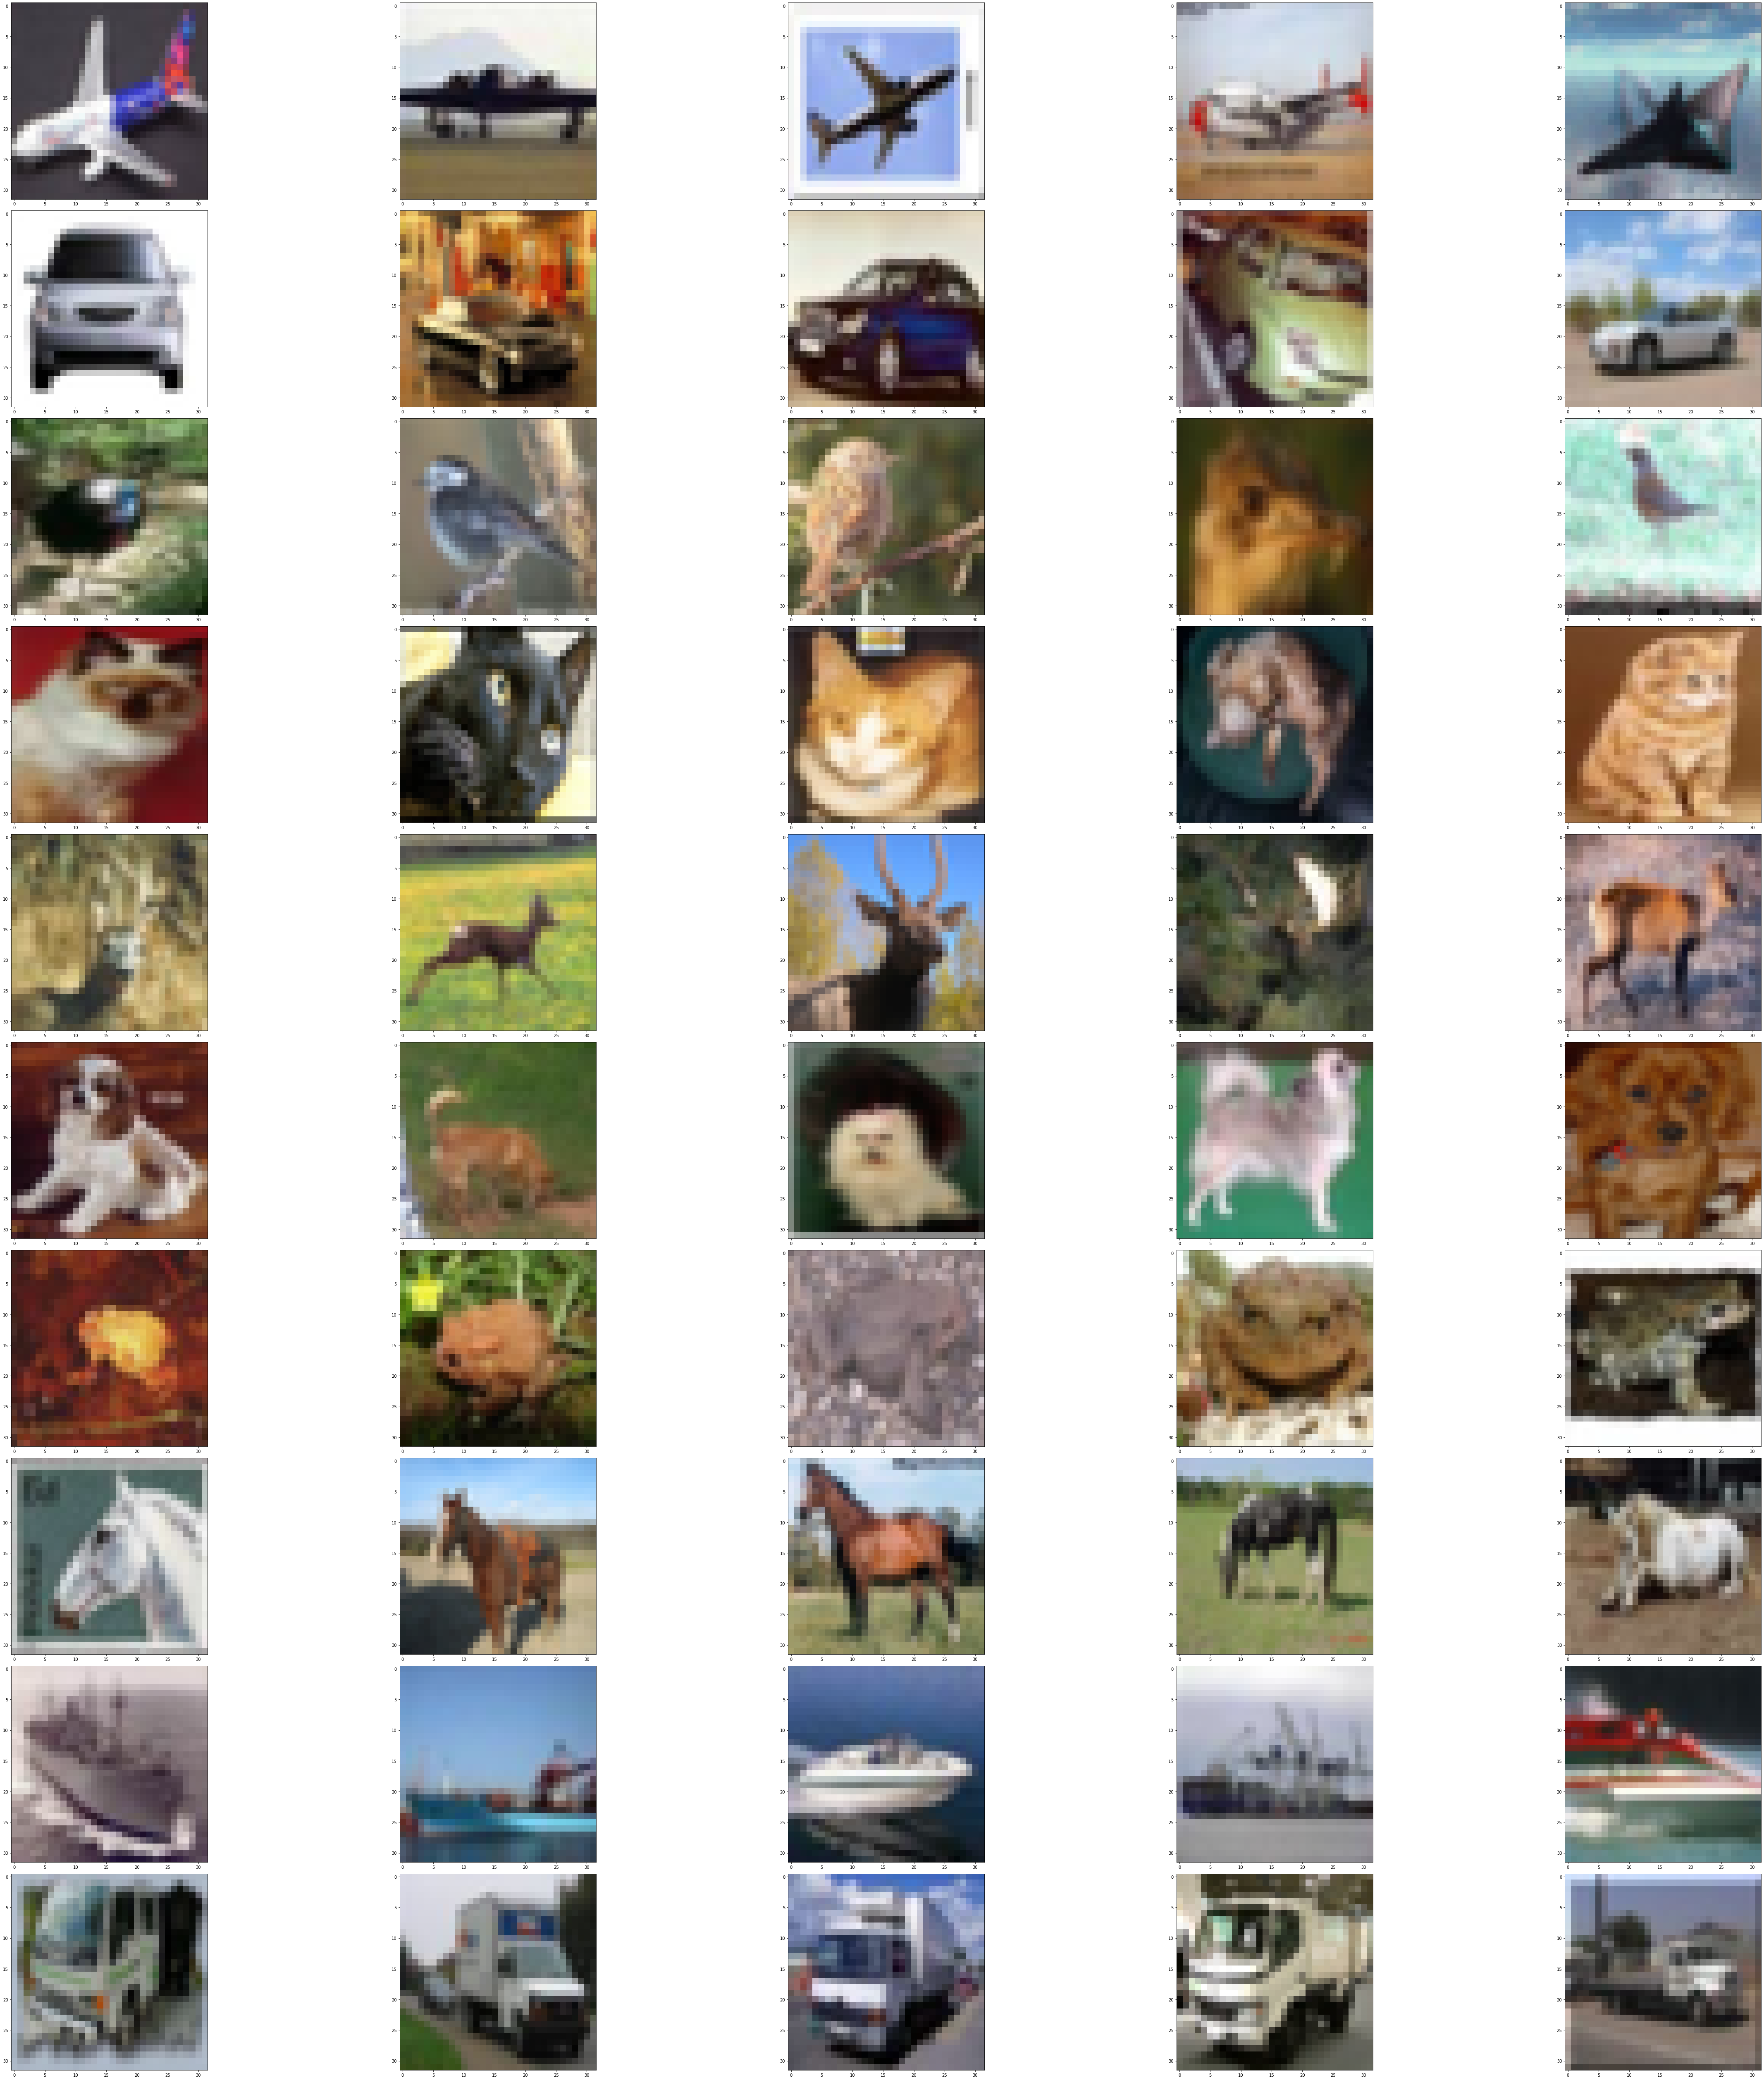

In [ ]:
##Import plotting package
import matplotlib.pyplot as plt

##Use function to plot random image from previous notebooks
##Define a function that will display random samples for each class for us
def display_rand_samples(labels,num_samples,imgData_x,imgData_y):
  
  ##Create figure to output images onto
  fig, ax = plt.subplots(len(labels),num_samples,figsize=(70,70))

  ##Loop through labels to display random samples for each label onto subplot
  ct = 0
  for i in labels:
    randomSamples = imgData_x[np.random.choice(np.argwhere(imgData_y==i).flatten(),num_samples)]
    for j in range(num_samples):
      ax[ct,j].imshow(randomSamples[j],cmap='gray')
    ct+=1

  fig.tight_layout()

##Call the function to plot random observations from each super-class (coarse labels)
np.random.seed(2) ##Set random seed so visualization results can be replicated
display_rand_samples(list(np.unique(y_train_10)),5,x_train_10,y_train_10)

Observing the random CIFAR-10 samples above, here are some observations of what I think the weights from Task A should be good at doing, keep in mind these observations are subjective hypothesis and not fact:
* Task A Network weights should help a Task B better identify machinery vs. non-machinery images
  * This is because we can see that CIFAR-10 has a mix of animal labels (horse, dog, etc) and machine labels (truck, plane, car, etc) and therefore must be able to identify what is machine and what is not. A Task A that requires a similar classification would be advantageous to have transfer learning with this Task B. It is the case that ImageNet classification similarly has to identify many machine vs. non-machine classes so transfer learning should work well. 

From previous study, we know that CIFAR-10 has perfect label balance among classes in the training set, so we don't need to worry about this. 

<b>Fashion MNIST EDA:</b> 

One thing that we must be aware of with the Fashion MNIST dataset, is that while ImageNet and CIFAR-10 datasets convienently have same image input channel dimensions, the Fashion MNIST dataset does not as it is grayscale. To resolve this difference, I will edit the dimensions of the Fashion MNIST dataset to be 32x32x3 dimensions. 

Import Fashion MNIST Data:

In [ ]:
##Must import open cv
import cv2

##Import the fashion mnist dataset
(x_train_fash, y_train_fash), (x_test_fash, y_test_fash) = tf.keras.datasets.fashion_mnist.load_data()
assert x_train_fash.shape == (60000, 28, 28)
assert x_test_fash.shape == (10000, 28, 28)
assert y_train_fash.shape == (60000,)
assert y_test_fash.shape == (10000,)

4431872/4422102 [==============================] - 0s 0us/step


Transform dimensions to be RGB

In [ ]:
##Create new sets
x_train_fash_new = []
x_test_fash_new = []

##Iterate through x_train and x_test fashion data for Grayscale --> RGB
for i in range(len(x_train_fash)):
  x_train_fash_new.append(cv2.cvtColor(x_train_fash[i], cv2.COLOR_GRAY2RGB))
for i in range(len(x_test_fash)):
  x_test_fash_new.append(cv2.cvtColor(x_test_fash[i], cv2.COLOR_GRAY2RGB))

##Display new Fashion MNIST dimensions
print('Dimensions of RGB Fashion MNIST Input Data:')
print('Height = '+str(x_train_fash_new[0].shape[0])+', Width = '+str(x_train_fash_new[0].shape[1])+', Channel = '+str(x_train_fash_new[0].shape[2]))

##Overwrite original data
x_train_fash = np.array(x_train_fash_new)
x_test_fash = np.array(x_test_fash_new)

##Free up some storage space on RAM
del x_train_fash_new
del x_test_fash_new

Dimensions of RGB Fashion MNIST Input Data:
Height = 28, Width = 28, Channel = 3


Now lets plot a couple random observations from each class to determine that we have done this transformation correctly:

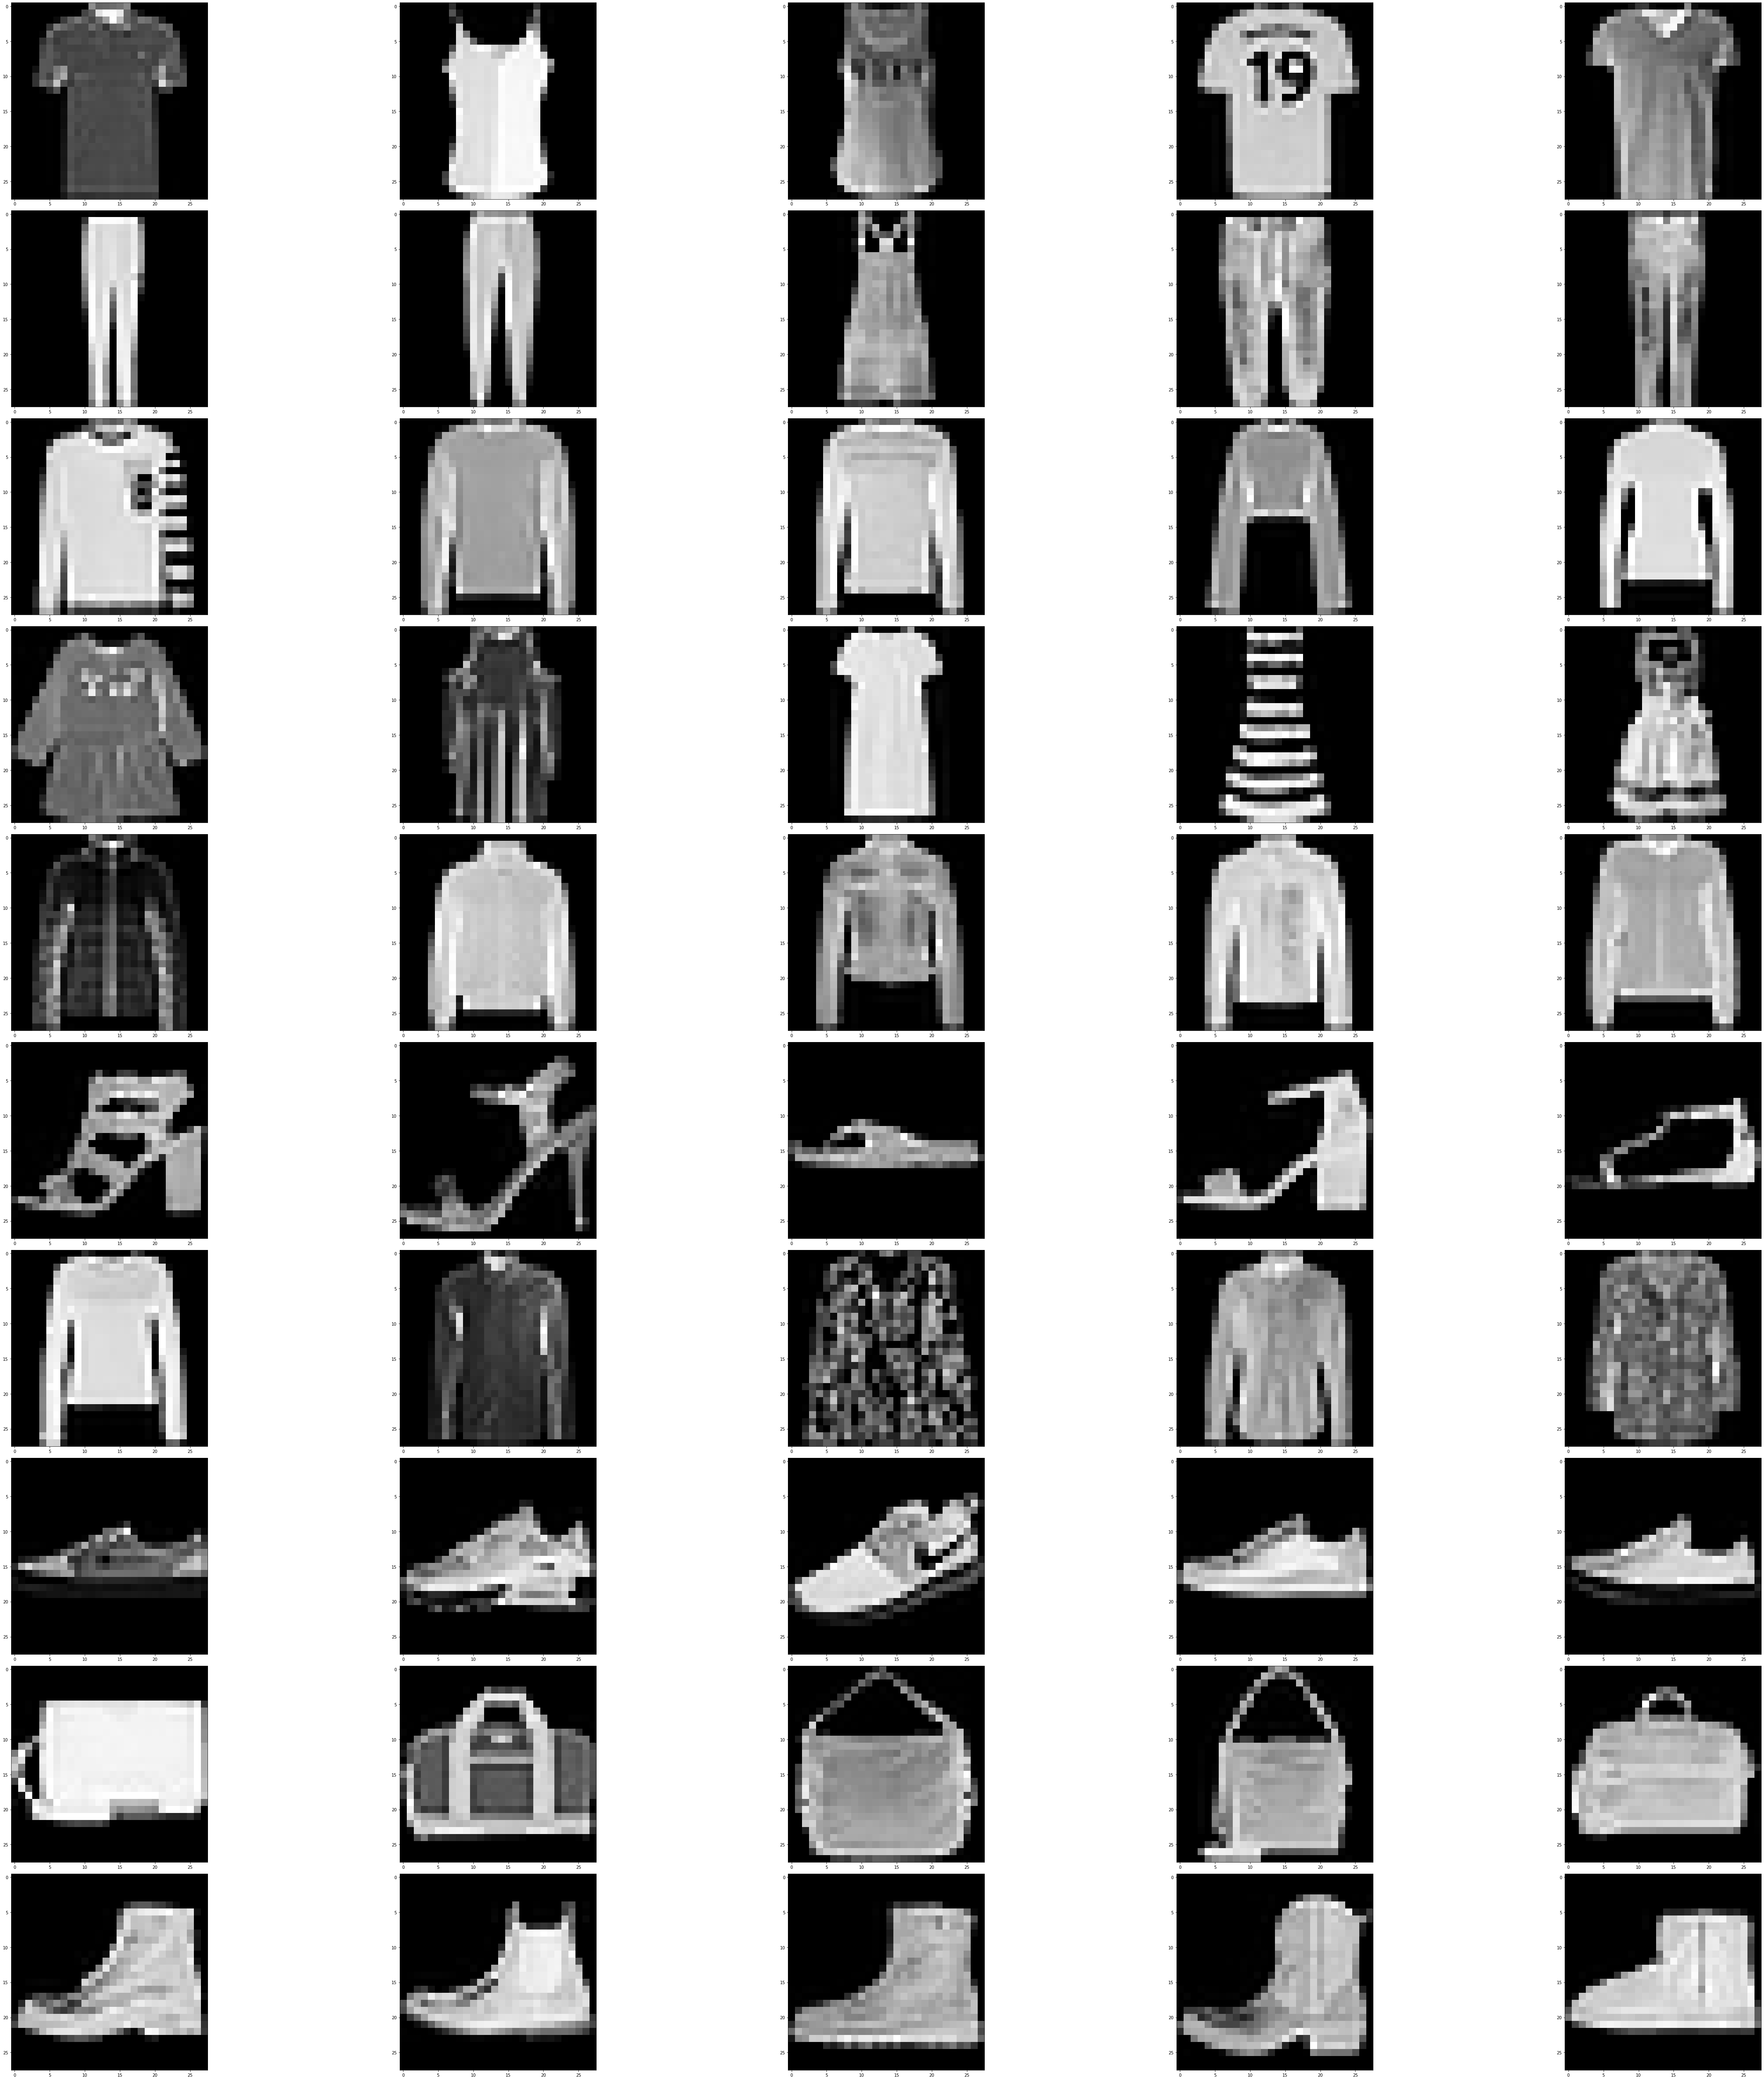

In [ ]:
##Call function to perform random plotting
np.random.seed(2) ##Set random seed so visualization results can be replicated
display_rand_samples(list(np.unique(y_train_fash)),5,x_train_fash,y_train_fash)

It seems that the transformation from Grayscale to RGB to increase the channel dimensions to be the same as ImageNet data (Task A) has been performed correctly. 

An additional transformation I want to perform is to now increase the fashion datasets dimensions from $H=28, W=28$ to $H=32, W=32$. It would also be interesting to try and do so in a new and "intelligent manner". Below I will collect the mean, median, and standard deviation values of the Fashion MNIST color channels for each individual image, and then I will build a Support Vector Machine classifier to predict which label the image belongs to. I will then use this label prediction to fill in the image and increase the image resolution from 28x28 to 32x32. I've made a visualization below to express what I mean: 

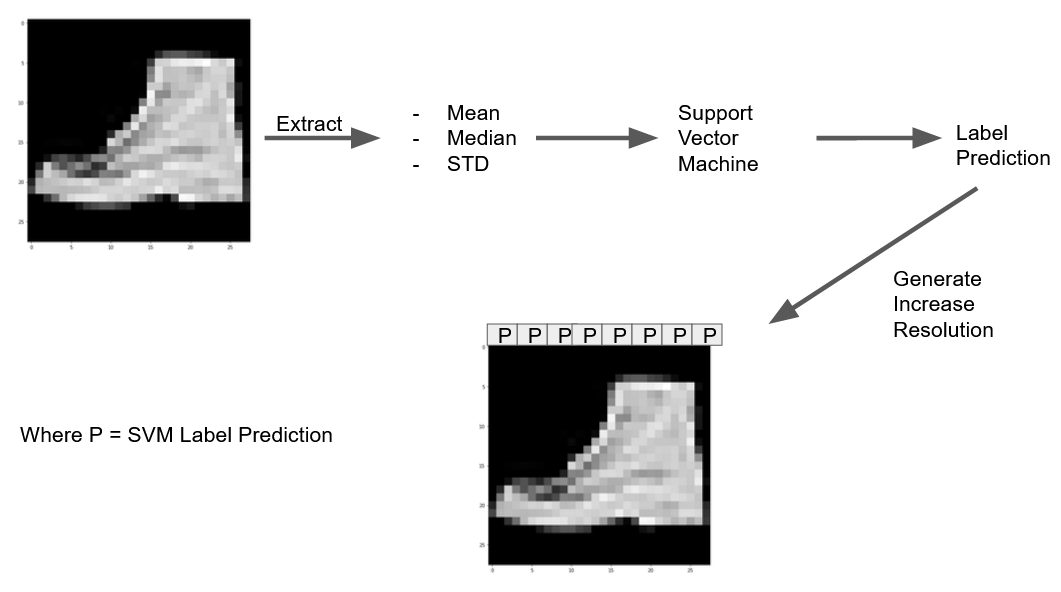

In a way this approach is kind of similar to the concept of transfer learning in that it uses another classification model to help aid in the prediction of a new classification model. Notice in the figure above I only padded the upper side of the image with the SVM label predictions, that was just for visual purposes, below you'll see that the whole outside rim of the image is padded. 

During implementation, I also scaled the predictions to fit between 0 and 255 so that the differences in prediction values for images could be better visualized and noted by the Neural Network. 

Below I will extract this information from the images and create a Support Vector Machine Classifier:

In [ ]:
##Create an empty location for the data that will be used to train the naive bayes classifier
x_data = []
y_data = []

##Loop through the data to add it to list
##Training Data
for i in range(len(x_train_fash)):
  mean = np.mean(x_train_fash[i]) 
  med = np.median(x_train_fash[i]) 
  std = np.std(x_train_fash[i])
  x_data.append([mean,med,std])
  y_data.append(y_train_fash[i]) 
##Test Data
for i in range(len(x_test_fash)):
  mean = np.mean(x_test_fash[i]) 
  med = np.median(x_test_fash[i]) 
  std = np.std(x_test_fash[i])
  x_data.append([mean,med,std])
  y_data.append(y_test_fash[i]) 

##Now cast these as numpy arrays
x_data = np.array(x_data)
y_data = np.array(y_data)

Now create and evaluate performance of the Support Vector Machine classifier:

In [ ]:
##Set a random seed so we get replicable results
np.random.seed(3)

##Import the appropriate model
from sklearn import svm

##Create a train/test split to test the effectiveness of the classifier
from sklearn.model_selection import train_test_split
x_train_svm, x_val_svm, y_train_svm, y_val_svm = train_test_split(x_data, y_data, test_size=0.15, random_state=42)

##Create the model and fit it to the training data
svm_model = svm.SVC(C=.5,kernel='rbf')
#naive_model = MultinomialNB()
svm_model.fit(x_train_svm,y_train_svm)

##Report the accuracy of the model
from sklearn.metrics import accuracy_score
predicted_y = svm_model.predict(x_val_svm)
svm_accuracy = accuracy_score(y_val_svm,predicted_y)

##Display the accuracy of the naive bayes model
print('Accuracy of Radial SVM Classifier')
print(round(svm_accuracy,4))

Accuracy of Radial SVM Classifier
0.3618


Although this model only has relatively low accuracy of 36.18%, it actually does decently well at predicting the 10 classes of the Fashion MNIST dataset considering it only intakes Mean, Median, and Standard Deviation information of an input image. 

Now lets use this model to increase the resolution of the images we have in the training and test set. Below I write a function to do so with some help from a Stack-Overflow source. 

In [ ]:
##Add prediction padding to image
##A helpful resource: https://stackoverflow.com/questions/43391205/add-padding-to-images-to-get-them-into-the-same-shape

##Define function that increases resolution based off model prediction
def increase_resolution(model, imgArray):

  ##Collect necessary information about the image array to generate a prediction
  mean = np.mean(imgArray) 
  med = np.median(imgArray) 
  std = np.std(imgArray)

  ##Format the datapoint
  dataPoint = np.array([[mean,med,std]])

  ##Generate label prediction using fitted model
  prediction = model.predict(dataPoint).item()

  #Create a new image with proper resolution and prediction value padding
  new_image_width = 32
  new_image_height = 32
  color = (prediction*27,prediction*27,prediction*27)
  result = np.full((new_image_height,new_image_width, 3), color, dtype=np.uint8)

  #Compute the new center of the image
  x_center = (new_image_width - 28) // 2
  y_center = (new_image_height - 28) // 2

  #Place original image into the center of the new generated image with padding
  result[y_center:y_center+28, 
        x_center:x_center+28] = imgArray

  return result

##Now crate new dataset with the proper resolutions for the fashion data

##Create new storage locations
x_train_fash_pad = []
x_test_fash_pad = []

##Iterate through training and test data to make new image result
for i in range(len(x_train_fash)):
  x_train_fash_pad.append(increase_resolution(svm_model, x_train_fash[i]))
for i in range(len(x_test_fash)):
  x_test_fash_pad.append(increase_resolution(svm_model, x_test_fash[i]))

##Correctly format the new data
x_train_fash_pad = np.array(x_train_fash_pad)
x_test_fash_pad = np.array(x_test_fash_pad)

##Overwrite previous data
x_train_fash = x_train_fash_pad
x_test_fash = x_test_fash_pad

##Display the resulting resolution
print('Dimensions of Padded RGB Fashion MNIST Input Data:')
print('Height = '+str(x_train_fash[0].shape[0])+', Width = '+str(x_train_fash[0].shape[1])+', Channel = '+str(x_train_fash[0].shape[2]))

Dimensions of Padded RGB Fashion MNIST Input Data:
Height = 32, Width = 32, Channel = 3


As we can see with the output above, now using this Predictive padding tactic that the resolutions of the Fashion MNIST images now match 32x32x3 dimensions. 

Now lets plot random examples from each class of the Fashion MNIST dataset below to observe what this padding looks like:

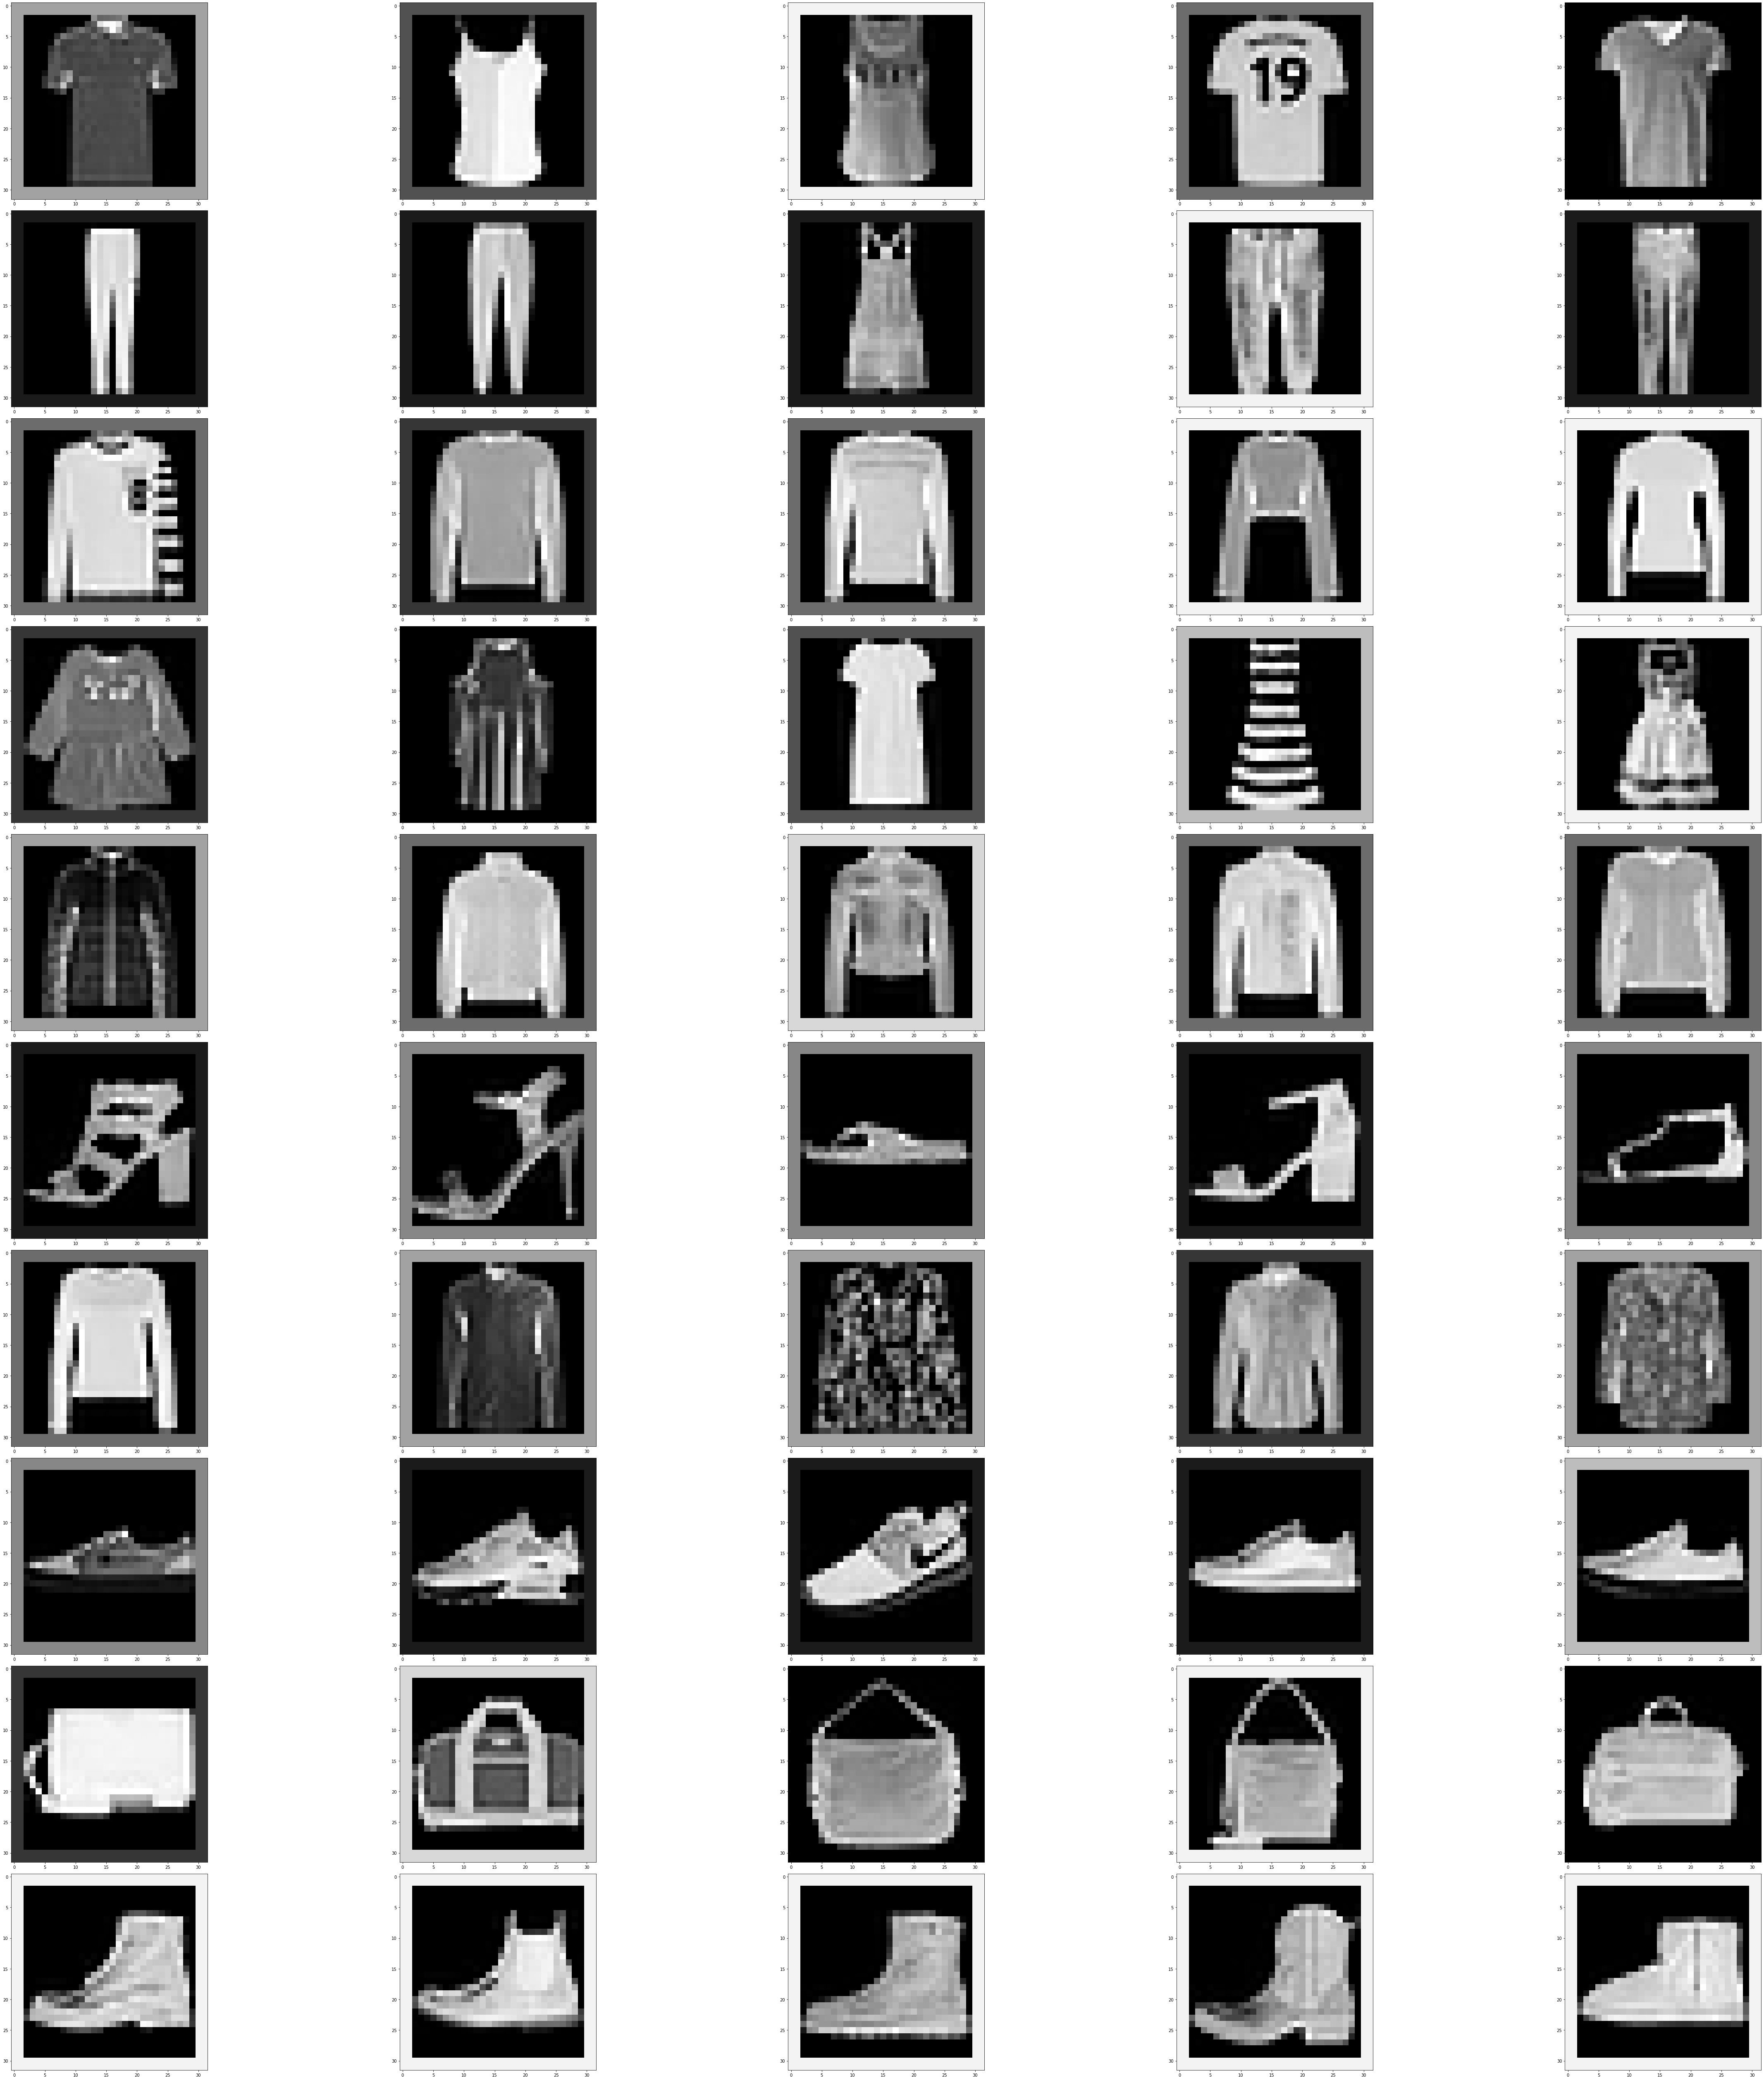

In [ ]:
##Display samples of padded Fashion Data
np.random.seed(2) ##Set random seed so visualization results can be replicated
display_rand_samples(list(np.unique(y_train_fash)),5,x_train_fash,y_train_fash)

Above we can note some observations about the results of using an SVM model to predict labels and using those predictions as padding for the images:
* In the 7th row, displaying the shirt class, the padded edges of the images are all similar gray colors, indicating the SVM is similarly labeling these images
* In row 9, displaying bags, we can see that the SVM classifier likely does a poor job in correctly labling these images, this is because the padded borders of the image range from bright white, to gray, to black, indicating they have drastically different labels
* In row 10, the ankle boot pictures all have pretty white padded edges, indicating the SVM is labeling ankle boots similarly in label which is a good sign!

Overall, these are some pretty cool results and I'm interested to see how they effect performance of a network as compared to my previous bi-weekly report where it wasn't necessary to increase image resolution on the Fashion MNIST dataset. 

Below, I will train a neural network using the same architecture I used in Bi-Weekly Report #5 to assess how well this method to increase image resolution works. The results of this network will also be compared to the transfer learning results obtained later on.

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, GlobalAveragePooling2D, Dropout

##Create class for a model (considered more "expert" on tensorflow site)
class FashionModel(Model):
    
    def __init__(self):
        
        super(FashionModel, self).__init__()
        self.conv1 = Conv2D(28,(1,1),activation='relu',input_shape=(32,32,3))
        self.batch1 = BatchNormalization()
        
        self.conv2 = Conv2D(64,(3,3),activation='relu')
        self.batch2 = BatchNormalization()
        
        self.conv3 = Conv2D(128,(3,3),activation='relu')
        self.batch3 = BatchNormalization()
        
        self.globAvgPool = GlobalAveragePooling2D() ##Aids in regularization
        
        self.d1 = Dense(128, activation='relu')
        self.drop = Dropout(.5)
        self.d2 = Dense(20, activation='softmax')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.conv3(x)
        x = self.batch3(x)
        x = self.globAvgPool(x)
        x = self.d1(x)
        x = self.drop(x)
        return self.d2(x)

In [ ]:
##Create an instance of the model that will be used to assess this padded approach
padModel = FashionModel()

In [ ]:
##Conduct a step of data normalization
x_train_fash, x_test_fash = x_train_fash / 255.0, x_test_fash / 255.0

##Perform train/validation split on the data
from sklearn.model_selection import train_test_split
x_train_fash1, x_val_fash1, y_train_fash1, y_val_fash1 = train_test_split(x_train_fash, y_train_fash, test_size=0.25, random_state=42)

In [ ]:
##Compile the model
padModel.compile(optimizer='adam',
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                             metrics=['accuracy'])

##Fit the model
pad_fit = padModel.fit(x_train_fash1, y_train_fash1, batch_size=32, epochs=50, validation_data=(x_val_fash1, y_val_fash1),verbose=2)

Epoch 1/50
1407/1407 - 22s - loss: 0.5670 - accuracy: 0.7986 - val_loss: 0.5867 - val_accuracy: 0.7869
Epoch 2/50
1407/1407 - 20s - loss: 0.4685 - accuracy: 0.8350 - val_loss: 0.4501 - val_accuracy: 0.8404
Epoch 3/50
1407/1407 - 20s - loss: 0.4167 - accuracy: 0.8517 - val_loss: 0.3594 - val_accuracy: 0.8661
Epoch 4/50
1407/1407 - 20s - loss: 0.3908 - accuracy: 0.8603 - val_loss: 0.3458 - val_accuracy: 0.8709
Epoch 5/50
1407/1407 - 20s - loss: 0.3712 - accuracy: 0.8672 - val_loss: 0.3484 - val_accuracy: 0.8705
Epoch 6/50
1407/1407 - 20s - loss: 0.3525 - accuracy: 0.8731 - val_loss: 0.3264 - val_accuracy: 0.8788
Epoch 7/50
1407/1407 - 20s - loss: 0.3383 - accuracy: 0.8789 - val_loss: 0.3097 - val_accuracy: 0.8874
Epoch 8/50
1407/1407 - 20s - loss: 0.3247 - accuracy: 0.8828 - val_loss: 0.3014 - val_accuracy: 0.8893
Epoch 9/50
1407/1407 - 20s - loss: 0.3126 - accuracy: 0.8876 - val_loss: 0.3423 - val_accuracy: 0.8708
Epoch 10/50
1407/1407 - 21s - loss: 0.3046 - accuracy: 0.8911 - val_loss:

In [ ]:
##Evaluate the testing accuracy of the model
print('Test Accuracy of SVM Padded Fashion Model:')
padModel.evaluate(x_test_fash,  y_test_fash, verbose=0)[1]

Test Accuracy of SVM Padded Fashion Model:


0.9031999707221985

I am relatively pleased with these results from above. Last week, my highest scoring model on the Fashion MNIST dataset scored a test accuracy of 90.21% This model with the increased resolution padded data increased accuracy to 90.31%, on a test set of 10,000 leading to an additional 10 images predicted correctly. Although thats not a huge increase it is something and it indicates that the Support Vector Machine padding might have added some predictive power to the data. Again, it seems like increasing image resolution in this way is a similar concept to transfer learning. We are predicting the image label with an SVM, then increasing the resolution of the image with the SVM's predicted label as new pixel values. So one model is using another models knowledge for prediction. 

This concludes EDA for <b>Fashion MNIST</b>. It will be interesting to see if Transfer Learning with the ImageNet dataset below does anything to further improve this Fashion MNIST Accuracy. 

#### Transfer Learning Experimentation

<b>Task A = ImageNet, Task B = Fashion MNIST</b>

Now I will use transfer learning with weights from the ResNet50 ImageNet model to help aid in predicting the Fashion MNIST dataset. As seen in the EDA and Fashion Nueral Network above, I am using the 3 Channel modified Fashion MNIST data that has additional predictive information in it from a Support Vector Machine model. 

Below I will define the transfer learning model for this problem environment, and then analyze all the results to view improvements in performance from above. 

Define the Architecture:

Useful resource for transfer learning help in tensorflow: https://www.tensorflow.org/tutorials/images/transfer_learning


In [ ]:
##Link Aiding in Creation of Transfer Learning Model: https://towardsdatascience.com/transfer-learning-for-image-classification-using-tensorflow-71c359b56673

##Import the ResNet50 Architecture
from tensorflow.keras.applications import ResNet50

#Obtain Imagenet model weights
feature_extractor = ResNet50(weights='imagenet', 
                             input_shape=(32, 32, 3),
                             include_top=False)

#For better performance, make it so that we are Fine-Tuning imagenet weights during transfer learning
feature_extractor.trainable = False

#Define dimensions for the
input_ = tf.keras.Input(shape=(32, 32, 3))

#Create layer that extracts features
x = feature_extractor(input_, training=False)

#Perform global average pooling to condense ResNet50 output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Set the final layer with sigmoid activation function
output_ = tf.keras.layers.Dense(10, activation='softmax')(x)

#Make an instance of the transfer learning architecture
fashion_transfer_model = tf.keras.Model(input_, output_)

#Compile the model
fashion_transfer_model.compile(optimizer='adam',
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                             metrics=['accuracy'])

# Print The Summary of The Model
fashion_transfer_model.summary()


94781440/94765736 [==============================] - 7s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In the model summary above we can see that we have an initial input layer that simply takes in our Fashion MNIST image data, and then the ResNet50 ImageNet weights will essentially do all the work and get sent to a final Dense Layer for classification. 

I am very interested to see how this Network performs, being new to Transfer Learning, it almost feel's like I am cheating by simply utilizing weights from a large pre-trained network. Its a very interesting concept, so lets train and see what happens! 

In [ ]:
##Fit and train the model
fashion_transfer_model_fit = fashion_transfer_model.fit(x_train_fash1, y_train_fash1, batch_size=32, epochs=50, 
                                   validation_data=(x_val_fash1, y_val_fash1),verbose=2)

Epoch 1/50
1407/1407 - 77s - loss: 1.1071 - accuracy: 0.6218 - val_loss: 0.9126 - val_accuracy: 0.6627
Epoch 2/50
1407/1407 - 43s - loss: 0.8028 - accuracy: 0.7177 - val_loss: 0.7461 - val_accuracy: 0.7313
Epoch 3/50
1407/1407 - 43s - loss: 0.7321 - accuracy: 0.7359 - val_loss: 0.6944 - val_accuracy: 0.7524
Epoch 4/50
1407/1407 - 43s - loss: 0.6911 - accuracy: 0.7482 - val_loss: 0.6771 - val_accuracy: 0.7593
Epoch 5/50
1407/1407 - 43s - loss: 0.6711 - accuracy: 0.7525 - val_loss: 0.7334 - val_accuracy: 0.7239
Epoch 6/50
1407/1407 - 43s - loss: 0.6501 - accuracy: 0.7603 - val_loss: 0.6322 - val_accuracy: 0.7716
Epoch 7/50
1407/1407 - 43s - loss: 0.6355 - accuracy: 0.7662 - val_loss: 0.6608 - val_accuracy: 0.7494
Epoch 8/50
1407/1407 - 43s - loss: 0.6214 - accuracy: 0.7697 - val_loss: 0.6362 - val_accuracy: 0.7683
Epoch 9/50
1407/1407 - 43s - loss: 0.6126 - accuracy: 0.7741 - val_loss: 0.6098 - val_accuracy: 0.7765
Epoch 10/50
1407/1407 - 43s - loss: 0.6072 - accuracy: 0.7770 - val_loss:

Assess the Accuracy of the Model:

In [ ]:
##Evaluate the testing accuracy of the model
print('Test Accuracy of Fashion MNIST ImageNet Transfer Learning:')
fashion_transfer_model.evaluate(x_test_fash,  y_test_fash, verbose=0)[1]

Test Accuracy of Fashion MNIST ImageNet Transfer Learning:


0.7773000001907349

These results were a tad under-whelming as the ending Test Accuracy was only 77.73% as opposed to 90.31% above without transfer learning. That being said, I have a couple of ideas on why the performance was so poor compared to not using transfer learning:
* SVM Prediction labels that increased resolution might have added noise to classification considering ImageNet images do not have these same label paddings
* Only having a single Softmax Dense Layer after the ImageNet weights prohibited the network from learning enough about the Fashion dataset even with the ImageNet weights

The main lesson I think I have learned from the Fashion MNIST results is that I should try adding more layers after the ImageNet convolutional layers to allow the network to learn more specific details about the Fashion MNIST data. That being said, I am still impressed that transfer learning worked so well. ImageNet transfer learning still allowed for nearly 78% accuracy on the Fashion dataset and this emphasizes its potential to improve many classification problems. 

Now we'll try transfer learning on CIFAR-10. I suspect transfer learning might increase the CIFAR-10 accuracy more than it did the Fashion MNIST accuracy. However it might also be true that I didn't add enough layers to the CIFAR-10 network after ImageNet convolutions for the data to be learned. 

<b>Task A = ImageNet, Task B = CIFAR-10</b>

In my most recent experimentation with classifying the full CIFAR-10 dataset, I achieved a test accuracy of 56%, so there is a ton of room for improvement. 

Let's use the same transfer learning architecture as above to create an instance of an ImageNet transfer learning model for CIFAR-10 classification:

In [ ]:
# Create the new model object
cifar_10_model = tf.keras.Model(input_, output_)

# Compile it
cifar_10_model.compile(optimizer='adam',
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                             metrics=['accuracy'])

We have not yet performed a validation/train split for Cifar-10, so lets go ahead and do that.

In [ ]:
##Conduct a step of data normalization
x_train_10, x_test_10 = x_train_10 / 255.0, x_test_10 / 255.0

##Perform train/validation split on the data
x_train_10, x_val_10, y_train_10, y_val_10 = train_test_split(x_train_10, y_train_10, test_size=0.25, random_state=42)

Now train the model:

In [ ]:
cifar_10_fit = cifar_10_model.fit(x_train_10, y_train_10, batch_size=32, epochs=50, 
                                   validation_data=(x_val_10, y_val_10),verbose=2)

Epoch 1/50
1172/1172 - 41s - loss: 3.3393 - accuracy: 0.1460 - val_loss: 2.7892 - val_accuracy: 0.1830
Epoch 2/50
1172/1172 - 36s - loss: 2.5832 - accuracy: 0.2073 - val_loss: 2.4162 - val_accuracy: 0.2332
Epoch 3/50
1172/1172 - 36s - loss: 2.3452 - accuracy: 0.2371 - val_loss: 2.2187 - val_accuracy: 0.2680
Epoch 4/50
1172/1172 - 36s - loss: 2.2117 - accuracy: 0.2618 - val_loss: 2.1061 - val_accuracy: 0.2865
Epoch 5/50
1172/1172 - 36s - loss: 2.1253 - accuracy: 0.2814 - val_loss: 2.0430 - val_accuracy: 0.3000
Epoch 6/50
1172/1172 - 36s - loss: 2.0528 - accuracy: 0.2959 - val_loss: 1.9993 - val_accuracy: 0.3193
Epoch 7/50
1172/1172 - 36s - loss: 1.9985 - accuracy: 0.3111 - val_loss: 2.0297 - val_accuracy: 0.2923
Epoch 8/50
1172/1172 - 36s - loss: 1.9642 - accuracy: 0.3203 - val_loss: 1.9039 - val_accuracy: 0.3429
Epoch 9/50
1172/1172 - 36s - loss: 1.9231 - accuracy: 0.3312 - val_loss: 1.9095 - val_accuracy: 0.3345
Epoch 10/50
1172/1172 - 36s - loss: 1.8983 - accuracy: 0.3405 - val_loss:

Assess the Test Results:

In [ ]:
##Evaluate the testing accuracy of the model
print('Test Accuracy of CIFAR-10 ImageNet Transfer Learning:')
cifar_10_model.evaluate(x_test_10,  y_test_10, verbose=0)[1]

Test Accuracy of CIFAR-10 ImageNet Transfer Learning:


0.4163999855518341

Transfer Learning using ResNet50 ImageNet weights did not increase the performance that I previously attained on the CIFAR-10 dataset. I think that again this can be contributed to the lack of convolutions or layers after the ImageNet weights in the classification network which prevents the model from learning enough about the CIFAR-10 data to classify it well. 

In the next notebook, <b>Enhanced_Transfer_Learning.ipynb</b>, I will try to improve upon the lessons learned in this preliminary study of transfer learning to make a more effective classifier for the CIFAR-100 dataset and hopefully achieve better results for that dataset than I have in the past. 


## Final Thoughts

This notebook was able to emphasize the power of Transfer Learning even without improving the results of either classification model. This is because essentially each model mainly used the ImageNet weights for training except for one last Dense Layer. This is very impressive and shows that much of the knowledge stored in the ImageNet convolutions is extremely applicable to a variety of image classification problems. Now, I just need to find a proper mix of using transfer learning weights and additional layers specific to the current network. 